In [175]:
import numpy as np
import matplotlib.pyplot as plt

In [176]:
g = 9.81
z = 257.4 * 0.001
Tc = np.sqrt(z/g)
# supporting duration
T_sup = 0.6

In [177]:
def calc_basic_passing_foot_pos(v, T_sup):
    return Tc*v * (np.cosh(T_sup/Tc)-1) / np.sinh(T_sup/Tc)
def calc_basic_unpassing_foot_pos(v, T_sup):
    return Tc*v * (np.cosh(T_sup/Tc)+1) / np.sinh(T_sup/Tc)

def normalize_vel(v, v_mag):
    if v_mag > 0.34:
        return [0.34/v_mag*v[0], 0.34/v_mag*v[1], v[2]]
    else:
        return v
    
def calc_T_sup(v_mag):
    if v_mag < 0.25:
        return 0.6
    else:
        return 0.6 - 0.3 * ( (v_mag - 0.25) / (0.34 - 0.25) )

def calc_y_vel(y0, T_sup):
    return (y0/Tc) * ( np.sinh(T_sup/Tc) / ( -1 - np.cosh(T_sup/Tc) ) )

In [178]:
def calc_LIP_p(t, cp0, cv0):
    x_t = cp0[0] * np.cosh(t/Tc) + Tc * cv0[0] * np.sinh(t/Tc)
    y_t = cp0[1] * np.cosh(t/Tc) + Tc * cv0[1] * np.sinh(t/Tc)
    return [x_t, y_t]

def calc_LIP_v(t, cp0, cv0):
    vx_t = cp0[0] / Tc * np.sinh(t/Tc) + cv0[0] * np.cosh(t/Tc)
    vy_t = cp0[1] / Tc * np.sinh(t/Tc) + cv0[1] * np.cosh(t/Tc)
    return [vx_t, vy_t]

def calc_LIP_com(T_sup, cp0, cv0, double_support_ratio):
    n = int(T_sup / 0.01) + 1

    traj = []

    for i in range(int(n*(double_support_ratio/2)), int(n*(1- double_support_ratio/2))+1):
        t = i * 0.01
        pos = calc_LIP_p(t, cp0, cv0)
        traj.append(pos)

    return traj

In [179]:
def calc_double_support_com(T_ds, cpn_d_0, cvn_d_0, can_d_0, cpn_d_T, cvn_d_T, can_d_T):
    # print(f"cpn_d_0: {cpn_d_0}, cvn_d_0: {cvn_d_0}, can_d_0: {can_d_0}")
    # print(f"cpn_d_T: {cpn_d_T}, cvn_d_T: {cvn_d_T}, can_d_T: {can_d_T}")

    n = int(T_ds / 0.01) + 1
    traj = []

    a0 = cpn_d_0
    a1 = cvn_d_0
    a2 = [1/2*can_d_0[0], 1/2*can_d_0[1]]

    a3_x = 1/(2*T_ds**3) * ( 20*(cpn_d_T[0]-cpn_d_0[0]) - (8*cvn_d_T[0] + 12*cvn_d_0[0])*T_ds - (3*can_d_0[0] - can_d_T[0])*T_ds**2 )
    a3_y = 1/(2*T_ds**3) * ( 20*(cpn_d_T[1]-cpn_d_0[1]) - (8*cvn_d_T[1] + 12*cvn_d_0[1])*T_ds - (3*can_d_0[1] - can_d_T[1])*T_ds**2 )
    a3 = [a3_x, a3_y]
    a4_x = 1/(2*T_ds**4) * ( 30*(cpn_d_0[0]-cpn_d_T[0]) + (14*cvn_d_T[0] + 16*cvn_d_0[0])*T_ds + (3*can_d_0[0] - 2*can_d_T[0])*T_ds**2 )
    a4_y = 1/(2*T_ds**4) * ( 30*(cpn_d_0[1]-cpn_d_T[1]) + (14*cvn_d_T[1] + 16*cvn_d_0[1])*T_ds + (3*can_d_0[1] - 2*can_d_T[1])*T_ds**2 )
    a4 = [a4_x, a4_y]
    a5_x = 1/(2*T_ds**5) * ( 12*(cpn_d_T[0]-cpn_d_0[0]) - 6*(cvn_d_T[0] + cvn_d_0[0])*T_ds - (can_d_0[0] - can_d_T[0])*T_ds**2 )
    a5_y = 1/(2*T_ds**5) * ( 12*(cpn_d_T[1]-cpn_d_0[1]) - 6*(cvn_d_T[1] + cvn_d_0[1])*T_ds - (can_d_0[1] - can_d_T[1])*T_ds**2 )
    a5 = [a5_x, a5_y]

    def calc_traj(t):
        x = a0[0] + a1[0]*t + a2[0]*t**2 + a3[0]*t**3 + a4[0]*t**4 + a5[0]*t**5
        y = a0[1] + a1[1]*t + a2[1]*t**2 + a3[1]*t**3 + a4[1]*t**4 + a5[1]*t**5
        return [x, y]

    for i in range(n):
        t = i * 0.01
        pos = calc_traj(t)
        traj.append(pos)

    

    return traj

In [180]:
def calc_rot_angle_limit(cvn_last):
    # return 0 for too small vel
    if abs(cvn_last[0]) < 0.005 or abs(cvn_last[1]) < 0.005:
        return [0,0]

    a1 = np.arctan2(cvn_last[1], cvn_last[0])
    y_v_lim = 0.03 / Tc
    cv_mag = np.sqrt(cvn_last[0]**2 + cvn_last[1]**2)
    if cv_mag < y_v_lim: # if no concerns to pass the pivot
        a2 = 0.5
    else:
        a2 = np.arccos(y_v_lim / np.sqrt(cvn_last[0]**2 + cvn_last[1]**2))
    a2 = a2 * -1 * (a1/abs(a1))

    # reduce angle limits
    a1*=0.3
    a2*=0.3

    angle_limits = []
    if a1 > a2:
        angle_limits = [a1, a2]
    else:
        angle_limits = [a2, a1]
    # print("angle_limits:", angle_limits)
    return angle_limits

def rotate_vec(vec, angle):
    c = np.cos(angle)
    s = np.sin(angle)
    R = np.array([[c, -s],
                  [s,  c]])
    vec_rot = R @ np.array(vec)
    return vec_rot.tolist()

In [181]:
kpx = 0.01
kdx = 0.001

kpy = 0.01
kdy = 0.001

def px_pid(cvn_last, cvn_m1_last, vd):
    # print(f"cvn_m1_last: {cvn_m1_last}, cvn_last: {cvn_last}")
    err = vd[0]-cvn_last[0]
    derr = -cvn_last[0] + cvn_m1_last[0]
    # print(f"vel err: {err}, d_err: {derr}")

    px = calc_basic_passing_foot_pos(cvn_last[0], T_sup)
    # print("basic foot pos x:", px)

    px_r = px - kpx * err - kdx * derr

    # print("corrected foot pos x:", px_r)
    return px_r

def py_pid(cvn_last, cvn_m1_last, vd, pn, T_sup):
    # print(f"cvn_m1_last: {cvn_m1_last}, cvn_last: {cvn_last}")
    vd_sum = calc_y_vel(0.03 * -pn[1]/abs(pn[1]), T_sup) + vd[1]
    err = vd_sum + cvn_last[1]
    derr = -cvn_last[1] - cvn_m1_last[1]
    # print(f"vd_sum: {vd_sum}, vel err: {err}, d_err: {derr}")

    py = calc_basic_unpassing_foot_pos(cvn_last[1], T_sup)
    # print("basic foot pos y:", py)

    py_r = py - kpy * err - kdy * derr

    # print("corrected foot pos y:", py_r)
    return py_r

In [182]:
# com, pn: com and foot position from current foot position
cpn_last = [0, -0.03]
cvn_last = []

pn = [0,-0.03]

cvn_m1_last = [0, calc_y_vel(-pn[1], T_sup)]
cvn_last = calc_LIP_v(T_sup, [-pn[0], -pn[1]], cvn_m1_last)

# double support calculation
cpn_d_0 = [0,0]
cvn_d_0 = [0,0]
can_d_0 = [0,0]
cpn_d_T = []
cvn_d_T = []
can_d_T = []

T_sup_last = 0

In [183]:
vd = [0.1, 0.0, 0.5]
double_support_ratio = 0.2

foot_pos = []
cpn_last_history = []
traj_history = []

for i in range(35):
    print("step: ", i)
    if i < 8:
        vd = [0.1, 0.00, 0.5]
    elif i < 16:
        vd = [0.15, -0.05, -0.5]
    elif i < 24:
        vd = [-0.1, 0.05, -0.3]
    else:
        vd = [-0.1, -0.05, 0.3]
    
    # normalize vel and T_sup
    v_mag = np.sqrt(vd[0]**2 + vd[1]**2)
    vd = normalize_vel(vd, v_mag)
    v_mag = np.sqrt(vd[0]**2 + vd[1]**2)
    T_sup = calc_T_sup(v_mag)

    # decide angle
    angle_limits = calc_rot_angle_limit(cvn_last)
    rotation = vd[2]
    if rotation > 0:
        rotation = angle_limits[0] * abs(rotation)
    else:
        rotation = angle_limits[1] * abs(rotation)
    # rotate vel
    cvn_last = rotate_vec(cvn_last, rotation)

    # decide pn_p1
    px_p1 = px_pid(cvn_last, cvn_m1_last, vd)
    py_p1 = py_pid(cvn_last, cvn_m1_last, vd, pn, T_sup)
    pn_p1 = [px_p1, py_p1, rotation]
    # print("next foot pos pn_p1:", pn_p1)
    foot_pos.append(pn_p1)

    # calculate COM trajectory
    # from: n step com last, pivot: pn_p1
    cp0 = [-pn_p1[0], -pn_p1[1]]
    cv0 = cvn_last
    traj = calc_LIP_com(T_sup, cp0, cv0, double_support_ratio)

    # calculate double support trajectory
    # convert com information at the start of double support duration
    cpn_d_0 = rotate_vec(cpn_d_0, -rotation)
    cpn_d_0 = [cpn_d_0[0] - pn_p1[0], cpn_d_0[1] - pn_p1[1]]
    cvn_d_0 = rotate_vec(cvn_d_0, -rotation)
    can_d_0 = rotate_vec(can_d_0, -rotation)

    cpn_d_T = calc_LIP_p(T_sup*double_support_ratio/2, cp0, cv0)
    cvn_d_T = calc_LIP_v(T_sup*double_support_ratio/2, cp0, cv0)
    can_d_T = [cpn_d_T[0] / Tc**2, cpn_d_T[1] / Tc**2]

    T_ds = (T_sup + T_sup_last) * double_support_ratio/2
    double_support_traj = calc_double_support_com(T_sup*double_support_ratio,
                                                  cpn_d_0, cvn_d_0, can_d_0,
                                                  cpn_d_T, cvn_d_T, can_d_T)
    print(double_support_traj)

    # merge trajectory
    traj_merged = []
    traj_merged.extend(double_support_traj)
    traj_merged.extend(traj)
    traj_history.append(traj_merged)

    # update info
    pn = pn_p1
    cvn_m1_last = cvn_last
    cpn_last = calc_LIP_p(T_sup, cp0, cv0)
    cpn_last_history.append(cpn_last)
    cvn_last = calc_LIP_v(T_sup, cp0, cv0)

    cpn_d_0 = calc_LIP_p(T_sup*(1 - double_support_ratio/2), cp0, cv0)
    cpn_d_0 = [cpn_d_0[0] - cpn_last[0], cpn_d_0[1] - cpn_last[1]]
    cvn_d_0 = calc_LIP_v(T_sup*(1 - double_support_ratio/2), cp0, cv0)
    can_d_0 = [cpn_d_0[0] / Tc**2, cpn_d_0[1] / Tc**2]

    T_sup_last = T_sup
    print("-------------------")


step:  0
[[0.001, -0.03000000000000006], [0.0009999372899424355, -0.02998662272126268], [0.0009996156942742617, -0.029900317733984758], [0.0009990703777813278, -0.02968746350802464], [0.0009985992468452669, -0.0293137468244611], [0.0009986991047231033, -0.02876223450385707], [0.001000001806826861, -0.028031445134523353], [0.0010032104160031742, -0.027133420800782435], [0.001009035357812896, -0.02609179881123223], [0.0010181305758107063, -0.02493988342700978], [0.0010310296868247225, -0.023718717590055057], [0.0010480821362361067, -0.022475154651374698], [0.0010693893532586769, -0.02125993009930574]]
-------------------
step:  1
[[-0.02754568292202801, 0.03748576223653209], [-0.026778244990379372, 0.036236350368198715], [-0.025966416953930444, 0.034935462310368204], [-0.025071104631829867, 0.03353593266290033], [-0.02407759113253259, 0.03202634885680091], [-0.022990619852832635, 0.03042303088580146], [-0.021829477476895842, 0.028762011037938753], [-0.02062307697529265, 0.027091013627134

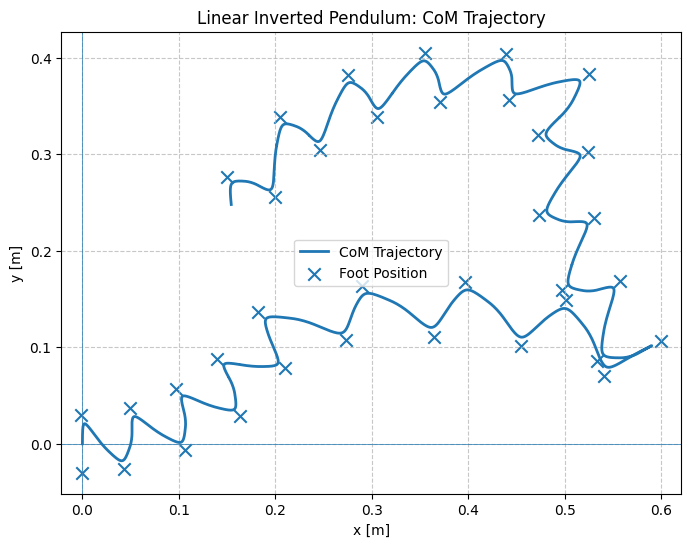

In [184]:
angle = 0.0
foot_all = [[0,-0.03]]
traj_all = []
traj_last = [0,0]
for i in range(len(foot_pos)):
    angle += foot_pos[i][2]
    # convert to world coordinate
    foot_pos_rot = rotate_vec([foot_pos[i][0], foot_pos[i][1]], angle)
    pivot = [0,0]
    pivot[0] = foot_pos_rot[0] + traj_last[0]
    pivot[1] = foot_pos_rot[1] + traj_last[1]

    traj = traj_history[i]
    for pos in traj:
        pos = rotate_vec(pos, angle)
        traj_all.append([pos[0]+pivot[0], pos[1]+pivot[1]])
    
    cpn_last_history_rot = rotate_vec(cpn_last_history[i], angle)
    traj_last = [cpn_last_history_rot[0]+pivot[0], cpn_last_history_rot[1]+pivot[1]]
    foot_all.append(pivot)

# CoM trajectory
x_coords = [pos[0] for pos in traj_all]
y_coords = [pos[1] for pos in traj_all]

# Foot positions
foot_x = [pos[0] for pos in foot_all]
foot_y = [pos[1] for pos in foot_all]

# 2. グラフの設定
plt.figure(figsize=(8, 6))

# CoM
plt.plot(x_coords, y_coords,
         label='CoM Trajectory',
         linewidth=2)

# Foot (pivot)
plt.scatter(foot_x, foot_y,
            marker='x',
            s=80,
            label='Foot Position')

# 3. 装飾
plt.title('Linear Inverted Pendulum: CoM Trajectory')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axhline(0, linewidth=0.5)
plt.axvline(0, linewidth=0.5)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.axis('equal')

# 4. 表示
plt.show()
